In [451]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [463]:
path = "/home/intern4/fm2026/fm_flow/code_it/logs"
run_idx = 74
run_ep = 20
log_root = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{run_idx:05d}_train/test/ep_{run_ep}")
res_files = sorted(log_root.glob("*.mat"))
print(len(res_files))

128


In [464]:
idx = 0
# idx = 100

In [465]:
# idx += 1
res_mat = loadmat(res_files[idx])
print(res_mat.keys())
print(res_mat['instruction'])

dict_keys(['__header__', '__version__', '__globals__', 'input', 'out', 'label', 'text', 'instruction'])
[[49406  7529   320 24938  6362  1694  2867   269 49407     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]


17
(512, 512) (512, 512) (472, 472)


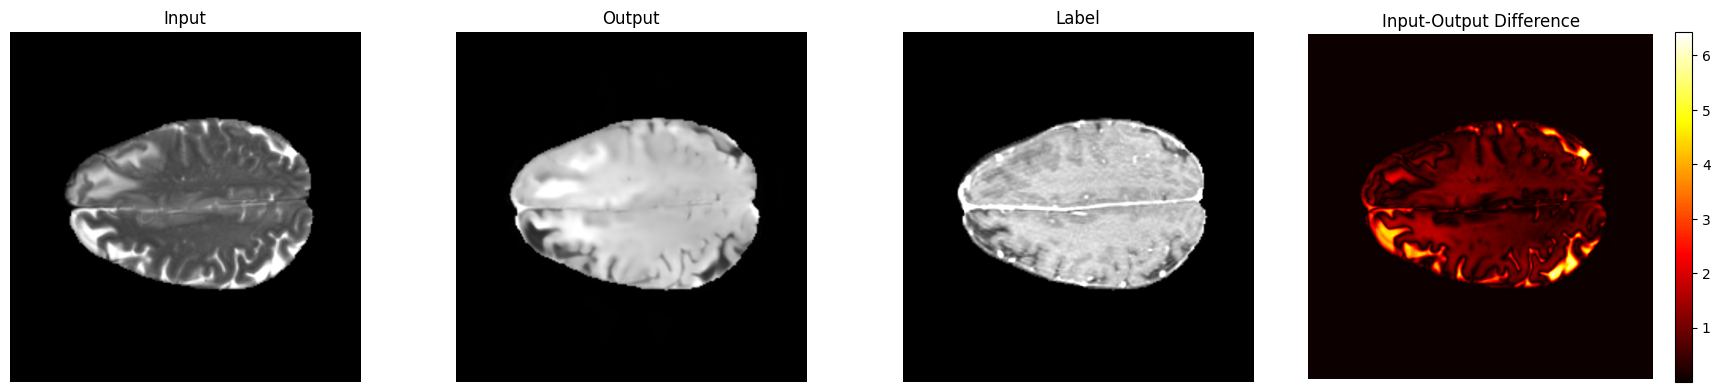

In [482]:
idx += 1
print(idx)

res_mat = loadmat(res_files[idx])
input = res_mat["input"].squeeze()
out = res_mat["out"].squeeze()
label = res_mat["label"].squeeze()

x1, x2, y1, y2 = 20, -20, 20, -20
# print("instruction: ", res_mat["instruction"][0])

vmin_input = np.percentile(input, 0.5)
vmax_input = np.percentile(input, 99.5)
vmin_out = np.percentile(out, 0.5)
vmax_out = np.percentile(out, 99.5)


plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Label")
plt.axis("off")
plt.subplot(1, 4, 4)
diff = np.abs(input[x1:x2, y1:y2] - out[x1:x2, y1:y2])
print(out.shape, input.shape, diff.shape)
plt.imshow(diff, cmap="hot")
plt.colorbar()
plt.title("Input-Output Difference")
plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
print(input.shape)
print(input.min(), input.max())
print(input.mean(), input.std())
print(input)

(512, 512)
-0.66907674 3.9484935
-2.6077032e-08 1.0
[[-0.66907674 -0.66907674 -0.66907674 ... -0.66907674 -0.66907674
  -0.66907674]
 [-0.66907674 -0.66907674 -0.66907674 ... -0.66907674 -0.66907674
  -0.66907674]
 [-0.66907674 -0.66907674 -0.66907674 ... -0.66907674 -0.66907674
  -0.66907674]
 ...
 [-0.66907674 -0.66907674 -0.66907674 ... -0.66907674 -0.66907674
  -0.66907674]
 [-0.66907674 -0.66907674 -0.66907674 ... -0.66907674 -0.66907674
  -0.66907674]
 [-0.66907674 -0.66907674 -0.66907674 ... -0.66907674 -0.66907674
  -0.66907674]]
